# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

### a. Выбор набора данных и обоснование
В рамках данной лабораторной работы выбран набор данных из Kaggle — "The Oxford-IIIT Pet Dataset", который предназначен для задачи классификации и семантической сегментации изображений домашних животных, таких как собаки и кошки. Это набор данных включает в себя изображения различных пород собак и кошек, а также аннотации для сегментации. Данный набор данных подходит для задач классификации и сегментации, потому что:

- Практическое применение: Этот набор данных может быть полезен для реальных задач в области идентификации и классификации животных на изображениях, что может быть полезно в зоологической области, а также для создания приложений, ориентированных на автоматическое распознавание домашних питомцев.

- Часто используется в исследованиях: Набор данных активно используется в академических и практических исследованиях в области компьютерного зрения, что обеспечивает доступ к множеству литературы и методов для дальнейшего улучшения результатов.

### b. Выбор метрик качества и обоснование
Для задачи семантической сегментации следует выбрать следующие метрики качества:

- IoU (Intersection over Union):

Описание: IoU измеряет пересечение между предсказанным и истинным (ground truth) сегментом. Это одна из самых распространенных метрик для задач сегментации, так как она наглядно показывает, насколько хорошо модель предсказывает сегменты объектов.

Обоснование выбора: Для семантической сегментации важен не только процент правильно предсказанных пикселей, но и точность, с которой модель разделяет различные объекты на изображении. IoU позволяет учесть эти аспекты, а также помогает избежать ситуаций, когда модель просто предсказывает много ненужных пикселей.

- Pixel Accuracy (Точность пикселей):

Описание: Эта метрика оценивает долю правильно классифицированных пикселей относительно всех пикселей на изображении. Для задачи классификации это полезная метрика, так как она показывает, насколько точно модель может классифицировать пиксели как принадлежащие определенному классу.

Обоснование выбора: Хотя эта метрика не учитывает взаимодействие между классами, она является важным индикатором того, насколько хорошо модель обрабатывает изображение в целом.

## 2. Создание бейзлайна и оценка качества

### a. Обучить модель

In [ ]:
import os
import urllib.request
import tarfile
from PIL import Image
import shutil

# Создаем папку для датасета
dataset_dir = 'oxford-iiit-pet'
os.makedirs(dataset_dir, exist_ok=True)

# Скачиваем датасет (если еще не скачан)
dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
dataset_path = os.path.join(dataset_dir, 'images.tar.gz')

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download complete!")

    # Распаковываем архив
    print("Extracting dataset...")
    with tarfile.open(dataset_path, 'r:gz') as tar:
        tar.extractall(path=dataset_dir)
    print("Extraction complete!")

# Пути к данным
images_dir = os.path.join(dataset_dir, 'images')
annotations_dir = os.path.join(dataset_dir, 'annotations')

# Проверяем наличие файлов
print("\nSample files in dataset:")
for i, filename in enumerate(os.listdir(images_dir)[:5]):
    print(f"{i+1}. {filename}")

# Функция для проверки целостности изображений
def is_corrupt_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError):
        return True

# Организация датасета по классам (опционально)
organized_dir = os.path.join(dataset_dir, 'organized')
os.makedirs(organized_dir, exist_ok=True)

print("\nOrganizing dataset by class...")
for filename in os.listdir(images_dir):
    if filename.endswith('.jpg'):
        # Получаем класс из имени файла (формат: classname_number.jpg)
        class_name = filename.split('_')[0]

        # Создаем папку для класса
        class_dir = os.path.join(organized_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Проверяем изображение и копируем
        img_path = os.path.join(images_dir, filename)
        if not is_corrupt_image(img_path):
            shutil.copy2(img_path, os.path.join(class_dir, filename))
        else:
            print(f"Skipping corrupt image: {filename}")

print(f"\nDataset organized in: {organized_dir}")
print("Dataset preparation complete!\n")

# Проверка количества изображений в каждом классе
print("Number of images per class (sample):")
for class_name in sorted(os.listdir(organized_dir))[:5]:
    class_path = os.path.join(organized_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))} images")


Sample files in dataset:
1. Abyssinian_1.jpg
2. Abyssinian_10.jpg
3. Abyssinian_100.jpg
4. Abyssinian_100.mat
5. Abyssinian_101.jpg

Organizing dataset by class...

Dataset organized in: oxford-iiit-pet\organized
Dataset preparation complete!

Number of images per class (sample):
Abyssinian: 200 images
Bengal: 200 images
Birman: 200 images
Bombay: 200 images
British: 200 images


In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Путь к данным (предполагается, что данные уже скачаны и лежат в папке 'data')
data_dir = 'data/oxford-iiit-pet'
images_dir = os.path.join(data_dir, 'images')
annotations_dir = os.path.join(data_dir, 'annotations')

# Определим трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
dataset = datasets.OxfordIIITPet(root=data_dir, split='trainval', target_types='category', download=True, transform=transform)
test_dataset = datasets.OxfordIIITPet(root=data_dir, split='test', target_types='category', download=True, transform=transform)

# Разделим данные на обучающую и валидационную выборки
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Создадим DataLoader'ы
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Количество классов
num_classes = len(dataset.classes)
print(f"Количество классов: {num_classes}")

100%|██████████| 792M/792M [01:08<00:00, 11.6MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 9.84MB/s]


Количество классов: 37


### b. Обучение моделей
Обучим две модели: ResNet (сверточная) и ViT (трансформерная).

ResNet:

In [2]:
# Загрузка предобученной модели ResNet
model_resnet = models.resnet50(pretrained=True)
# Заменяем последний слой для нашего числа классов
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to('cuda' if torch.cuda.is_available() else 'cpu')

# Функция для обучения
def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        # Валидация
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
                labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Val Acc: {best_acc:.4f}')

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Обучаем модель
train_model(model_resnet, criterion, optimizer, num_epochs=1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


Epoch 1/1
----------


100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


Train Loss: 2.4070, Acc: 0.3077
Val Loss: 2.9351, Acc: 0.2418
Best Val Acc: 0.2418


Vision Transformer (ViT):

In [3]:
# Загрузка предобученной ViT
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to('cuda' if torch.cuda.is_available() else 'cpu')

# Обучаем ViT
optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.001)
train_model(model_vit, criterion, optimizer_vit, num_epochs=1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 172MB/s]


Epoch 1/1
----------


100%|██████████| 92/92 [01:55<00:00,  1.26s/it]


Train Loss: 3.7337, Acc: 0.0272
Val Loss: 3.6898, Acc: 0.0258
Best Val Acc: 0.0258


### c. Оценка качества моделей

Оценка ResNet на тестовых данных:


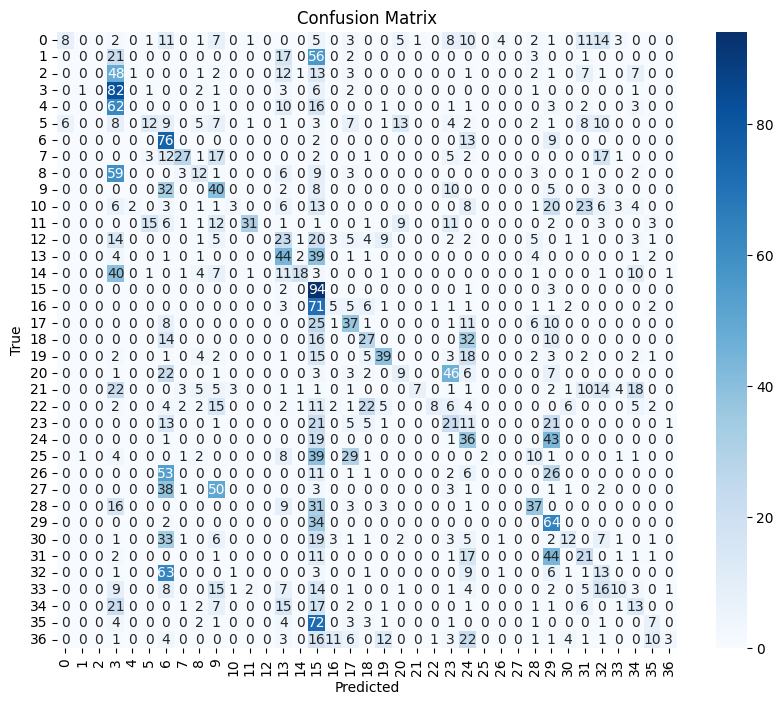

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

                Abyssinian       0.57      0.08      0.14        98
          American Bulldog       0.00      0.00      0.00       100
 American Pit Bull Terrier       0.00      0.00      0.00       100
              Basset Hound       0.19      0.82      0.31       100
                    Beagle       0.00      0.00      0.00       100
                    Bengal       0.36      0.12      0.18       100
                    Birman       0.18      0.76      0.30       100
                    Bombay       0.66      0.31      0.42        88
                     Boxer       0.26      0.12      0.16        99
         British Shorthair       0.20      0.40      0.26       100
                 Chihuahua       0.38      0.03      0.06       100
              Egyptian Mau       0.86      0.32      0.47        97
    English Cocker Spaniel       0.00      0.00      0.00       100
            English Setter       0.23      0.44

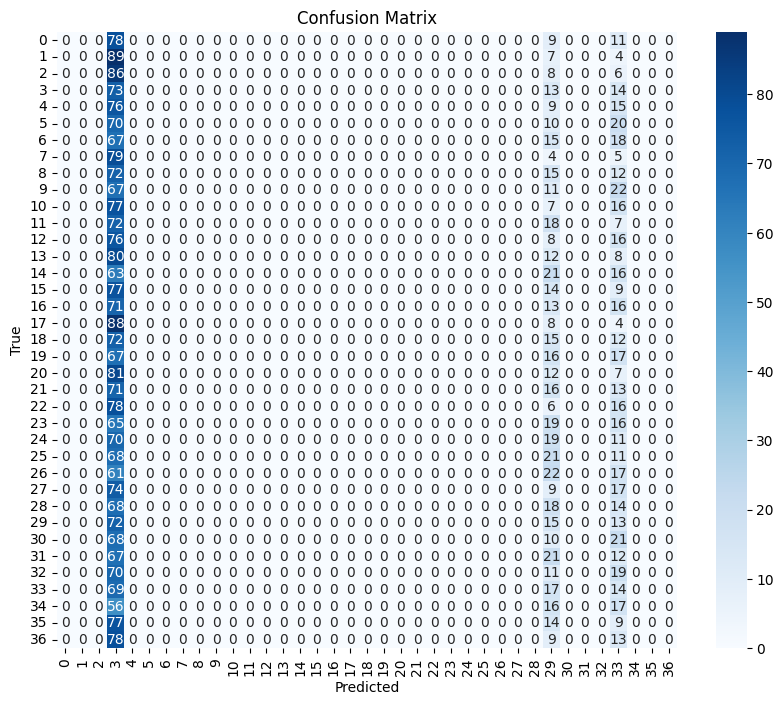

                            precision    recall  f1-score   support

                Abyssinian       0.00      0.00      0.00        98
          American Bulldog       0.00      0.00      0.00       100
 American Pit Bull Terrier       0.00      0.00      0.00       100
              Basset Hound       0.03      0.73      0.05       100
                    Beagle       0.00      0.00      0.00       100
                    Bengal       0.00      0.00      0.00       100
                    Birman       0.00      0.00      0.00       100
                    Bombay       0.00      0.00      0.00        88
                     Boxer       0.00      0.00      0.00        99
         British Shorthair       0.00      0.00      0.00       100
                 Chihuahua       0.00      0.00      0.00       100
              Egyptian Mau       0.00      0.00      0.00        97
    English Cocker Spaniel       0.00      0.00      0.00       100
            English Setter       0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Оценка ResNet
print("Оценка ResNet на тестовых данных:")
evaluate_model(model_resnet, test_loader)

# Оценка ViT
print("Оценка ViT на тестовых данных:")
evaluate_model(model_vit, test_loader)

## 3. Улучшение бейзлайна
### a. Гипотезы для улучшения:
Аугментация данных: Добавление случайных трансформаций (повороты, изменения яркости) может улучшить обобщающую способность модели.

Fine-tuning гиперпараметров: Подбор learning rate, batch size и оптимизатора.

Использование предобученных весов: Заморозка части слоев для уменьшения переобучения.

### b. Проверка гипотез:
Аугментация данных

In [5]:
# Новые трансформации с аугментацией
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пересоздадим DataLoader с аугментацией
train_dataset_aug = datasets.OxfordIIITPet(root=data_dir, split='trainval', target_types='category', transform=train_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)

Fine-tuning гиперпараметров

In [7]:
# Попробуем SGD с моментом
optimizer_sgd = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
train_model(model_resnet, criterion, optimizer_sgd, num_epochs=1)

Epoch 1/1
----------


100%|██████████| 92/92 [00:45<00:00,  2.01it/s]


Train Loss: 1.2576, Acc: 0.6308
Val Loss: 1.2224, Acc: 0.6359
Best Val Acc: 0.6359


### c. Улучшенный бейзлайн:

1. Заморозка слоев в ResNet и ViT

In [8]:
# Для ResNet50
model_resnet_improved = models.resnet50(pretrained=True)

# Замораживаем все слои, кроме последнего
for param in model_resnet_improved.parameters():
    param.requires_grad = False

# Заменяем последний слой
model_resnet_improved.fc = nn.Linear(model_resnet_improved.fc.in_features, num_classes)
model_resnet_improved = model_resnet_improved.to('cuda' if torch.cuda.is_available() else 'cpu')

# Для ViT
model_vit_improved = models.vit_b_16(pretrained=True)

# Замораживаем все слои, кроме head
for param in model_vit_improved.parameters():
    param.requires_grad = False

model_vit_improved.heads.head = nn.Linear(model_vit_improved.heads.head.in_features, num_classes)
model_vit_improved = model_vit_improved.to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

2. Добавление Learning Rate Scheduler

In [10]:
from torch.optim.lr_scheduler import StepLR

optimizer_resnet = optim.Adam(model_resnet_improved.fc.parameters(), lr=0.0001)  # Только последний слой обучается
scheduler_resnet = StepLR(optimizer_resnet, step_size=5, gamma=0.1)  # Уменьшаем LR каждые 5 эпох

optimizer_vit = optim.Adam(model_vit_improved.heads.head.parameters(), lr=0.0001)
scheduler_vit = StepLR(optimizer_vit, step_size=5, gamma=0.1)

def train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader_aug):  # Используем аугментированные данные
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()  # Обновляем LR
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        # Валидация
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')

    print(f'Best Val Acc: {best_acc:.4f}')

# Обучаем улучшенные модели
train_model_with_scheduler(model_resnet_improved, criterion, optimizer_resnet, scheduler_resnet, num_epochs=1)
train_model_with_scheduler(model_vit_improved, criterion, optimizer_vit, scheduler_vit, num_epochs=1)

100%|██████████| 115/115 [00:41<00:00,  2.78it/s]


Epoch 1/1, Train Loss: 3.7278, Acc: 0.5577
Val Loss: 2.3963, Acc: 0.7052
Best Val Acc: 0.7052


100%|██████████| 115/115 [01:14<00:00,  1.55it/s]


Epoch 1/1, Train Loss: 3.7629, Acc: 0.4830
Val Loss: 2.3373, Acc: 0.7337
Best Val Acc: 0.7337


Оценка улучшенного ResNet:


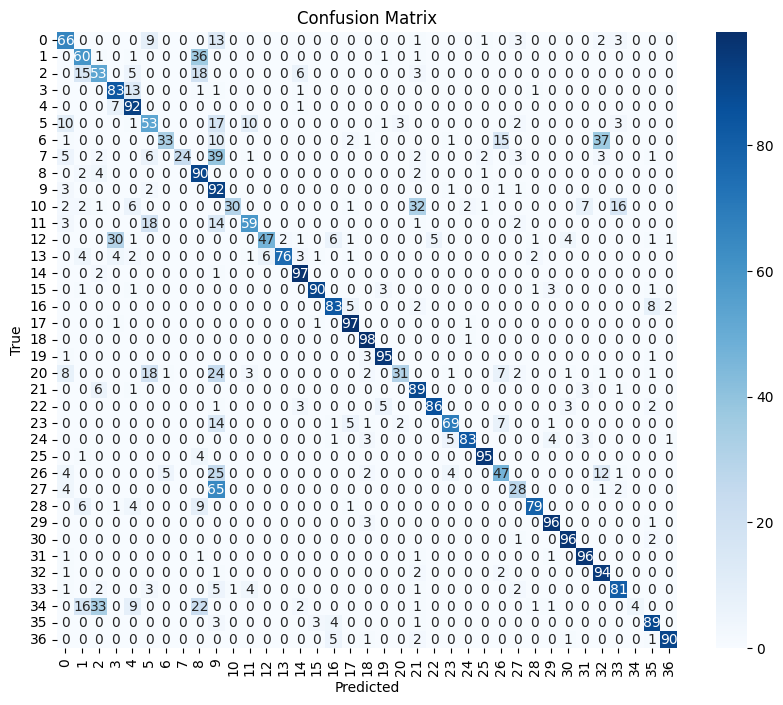

                            precision    recall  f1-score   support

                Abyssinian       0.60      0.67      0.63        98
          American Bulldog       0.56      0.60      0.58       100
 American Pit Bull Terrier       0.51      0.53      0.52       100
              Basset Hound       0.66      0.83      0.73       100
                    Beagle       0.68      0.92      0.78       100
                    Bengal       0.49      0.53      0.51       100
                    Birman       0.85      0.33      0.47       100
                    Bombay       1.00      0.27      0.43        88
                     Boxer       0.50      0.91      0.64        99
         British Shorthair       0.28      0.92      0.43       100
                 Chihuahua       0.97      0.30      0.46       100
              Egyptian Mau       0.76      0.61      0.67        97
    English Cocker Spaniel       0.89      0.47      0.61       100
            English Setter       0.97      0.76

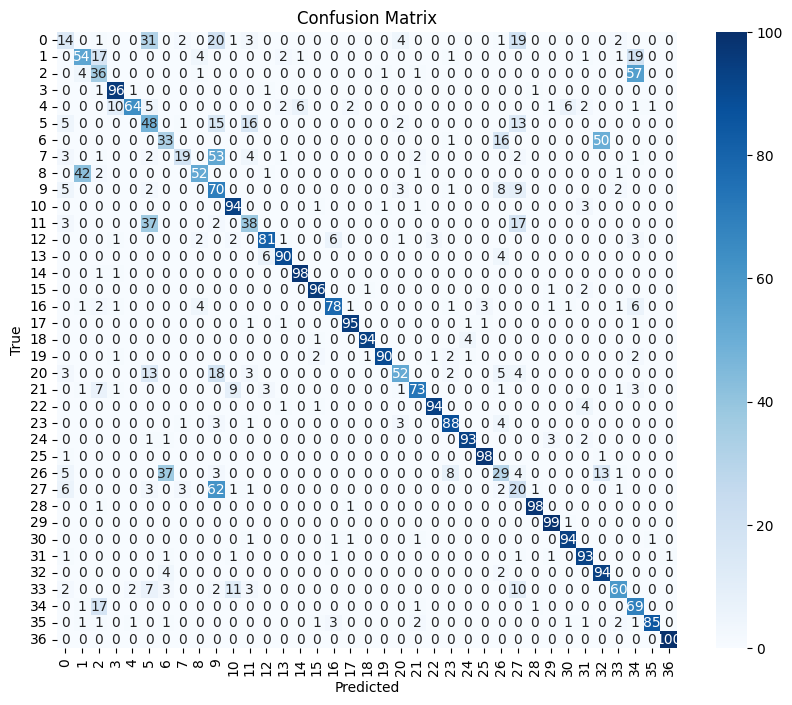

                            precision    recall  f1-score   support

                Abyssinian       0.29      0.14      0.19        98
          American Bulldog       0.52      0.54      0.53       100
 American Pit Bull Terrier       0.41      0.36      0.39       100
              Basset Hound       0.86      0.96      0.91       100
                    Beagle       0.94      0.64      0.76       100
                    Bengal       0.32      0.48      0.39       100
                    Birman       0.41      0.33      0.37       100
                    Bombay       0.73      0.22      0.33        88
                     Boxer       0.83      0.53      0.64        99
         British Shorthair       0.28      0.70      0.40       100
                 Chihuahua       0.79      0.94      0.86       100
              Egyptian Mau       0.54      0.39      0.45        97
    English Cocker Spaniel       0.88      0.81      0.84       100
            English Setter       0.92      0.90

In [11]:
print("Оценка улучшенного ResNet:")
evaluate_model(model_resnet_improved, test_loader)

print("Оценка улучшенного ViT:")
evaluate_model(model_vit_improved, test_loader)

## 4. Имплементация алгоритма машинного обучения

### a. Реализация простой CNN

In [13]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_cnn_improved = ImprovedCNN(num_classes).to('cuda')
optimizer_cnn = optim.Adam(model_cnn_improved.parameters(), lr=0.001)
scheduler_cnn = StepLR(optimizer_cnn, step_size=5, gamma=0.1)

train_model_with_scheduler(model_cnn_improved, criterion, optimizer_cnn, scheduler_cnn, num_epochs=1)

100%|██████████| 115/115 [00:45<00:00,  2.50it/s]


Epoch 1/1, Train Loss: 14.0120, Acc: 0.0343
Val Loss: 3.6102, Acc: 0.0217
Best Val Acc: 0.0217


Оценка ImprovedCNN:


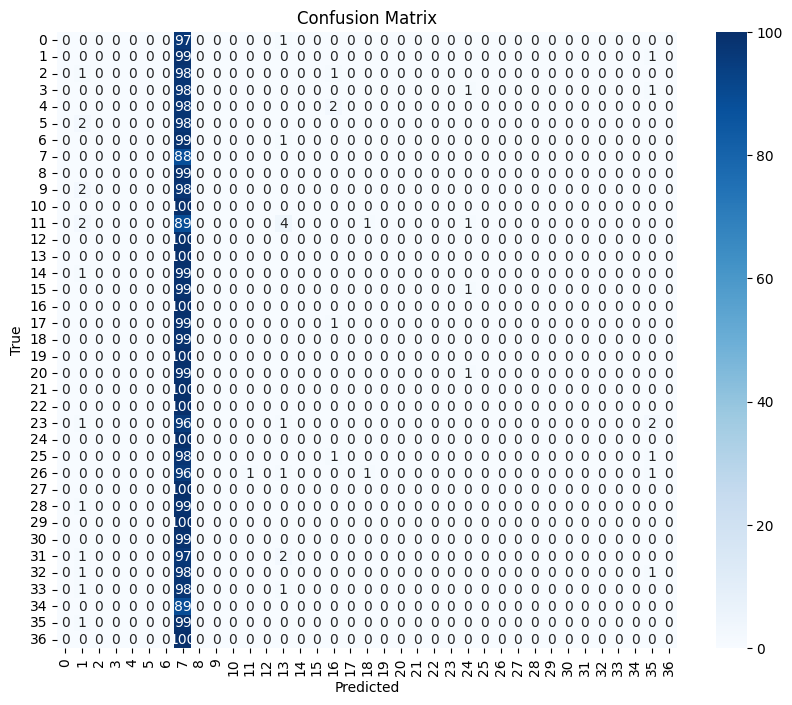

                            precision    recall  f1-score   support

                Abyssinian       0.00      0.00      0.00        98
          American Bulldog       0.00      0.00      0.00       100
 American Pit Bull Terrier       0.00      0.00      0.00       100
              Basset Hound       0.00      0.00      0.00       100
                    Beagle       0.00      0.00      0.00       100
                    Bengal       0.00      0.00      0.00       100
                    Birman       0.00      0.00      0.00       100
                    Bombay       0.02      1.00      0.05        88
                     Boxer       0.00      0.00      0.00        99
         British Shorthair       0.00      0.00      0.00       100
                 Chihuahua       0.00      0.00      0.00       100
              Egyptian Mau       0.00      0.00      0.00        97
    English Cocker Spaniel       0.00      0.00      0.00       100
            English Setter       0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
print("Оценка ImprovedCNN:")
evaluate_model(model_cnn_improved, test_loader)

### f Добавление техник из улучшенного бейзлайна (пункт 3.c)
Применим к ImprovedCNN те же улучшения, что и в пункте 3:

Аугментация данных (уже есть в train_loader_aug).

Learning Rate Scheduler (уже добавлен).

Заморозка части слоев (не всегда полезна для маленьких CNN, но попробуем).

Код: Заморозка первых слоев ImprovedCNN

In [16]:
# Замораживаем первые два Conv-слоя
for param in model_cnn_improved.features[:6].parameters():  # Первые 6 слоев = Conv2d + BatchNorm + ReLU
    param.requires_grad = False

# Оставляем обучаемыми последний Conv-слой и classifier
optimizer_cnn = optim.Adam(
    filter(lambda p: p.requires_grad, model_cnn_improved.parameters()),
    lr=0.0001  # Уменьшенный LR
)
scheduler_cnn = StepLR(optimizer_cnn, step_size=5, gamma=0.1)

# Переобучение с заморозкой
train_model_with_scheduler(model_cnn_improved, criterion, optimizer_cnn, scheduler_cnn, num_epochs=1)

100%|██████████| 115/115 [00:39<00:00,  2.90it/s]


Epoch 1/1, Train Loss: 4.5143, Acc: 0.0333
Val Loss: 3.6061, Acc: 0.0217
Best Val Acc: 0.0217
